# Investigating the impact of rainfall on the NDVI of Braunton Burrows, North Devon

This notebook was created to fulfill the requirements of [GY7709 - Satellite Data Analysis in Python](https://le.ac.uk/modules/2020/gy7709). The aim of the assignment was to apply remote sensing technology and the python programming language to explore an environmental application. 

The effect of rainfall on the NDVI of [Braunton Burrows, North Devon](https://www.visitdevon.co.uk/northdevon/things-to-do/braunton-burrows-p2526273) will be investigated. 

**The main questions to ask here are:**
* Are identical pixels getting *greener* over time?
* Given some lag time, is there a relationship between rainfall at Braunton Burrows, and the NDVI of the dunes?
  - And if there is a relationship, can it be modelled and how siginificant is it? 

**Acronyms**

* AOI = area of interest (Saunton Sands and Braunton Burrows)
* NDVI = Normalized Difference Index 

**This notebook is broken down into multiple sections**
1. Housekeeping 
2. Definging the study area
3. Defining an NDVI function with Google Earth Engine
4. Accessing NDVI's from 1980's- 2000's
5. Creating statistics of retreived images
6. Assessing weather data at Chivenor
7. Building a simple linnear regression model 
8. Conclusion 
9. Future work
10. Appendix

**Data**:
* [Landsat 5 surface reflectance](https://www.usgs.gov/core-science-systems/nli/landsat/landsat-surface-reflectance?qt-science_support_page_related_con=0#qt-science_support_page_related_con)
* [MetOffice Chivenor weather data](https://www.metoffice.gov.uk/pub/data/weather/uk/climate/stationdata/chivenordata.txt)


# 1. Housekeeping

Please modify the pathway to your own folider, holding the ```chivenor.csv``` and shape files in ```section 1.c```

## 1.a - Libraries 

In [ ]:
# Installing libraries
!pip install rasterio
!pip install rasterstats
!pip install geopandas

In [ ]:
# Google drive 
from google.colab import drive

# Google Earth Engine 
import ee
from ee import batch

# Directory structure 
import os
from os import listdir
from os.path import isfile, isdir, join
import shutil
import sys
import zipfile

# Data retreival
import requests
import io
import webbrowser
import urllib.request

# CRS management 
import geopandas as gpd
from osgeo import gdal, ogr
import json

# Raster management 
import rasterio as rio
import rasterstats
from rasterstats import zonal_stats

# Machine learning

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from statsmodels.stats.diagnostic import normal_ad

# Visualisation
from rasterio import plot
from rasterio.plot import show
from rasterio.plot import show_hist
from yellowbrick.regressor import ResidualsPlot
import matplotlib.pyplot as plt
from pprint import pprint
import imageio
import seaborn as sns
%matplotlib inline

# Data structures
import numpy as np
import math
import datetime
import pandas as pd

## 1.b GEE and Drive authentification

In [ ]:
# Connect to Google Earth Engine API
# This will open a web page where you have to enter your account information and a code is provided. Paste it in the terminal.
!earthengine authenticate
drive.mount('/content/drive')
ee.Initialize()

Instructions for updating:
non-resource variables are not supported in the long term
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=34OACvKhr92-J4AyIyeDuV_55f-dX08dW0BWA4NjoW4&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g7CxtKWpr2zNry7Tw8BBzfZ_yhCRWZUxHxOIjswt6DSaUY7CwfVFZg

Successfully saved authorization token.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.

## 1.c Pathways

The only thing necessary to make this Google Notebook work is a folder somewhere on your Google Drive with the shape files and ```chivenor.csv``` inside. That folder is then pointed to at ```aux_files```

* ```aux_files``` = A local directory on your google drive directory, holding the shapefiles and the ```chivenor.csv```
 

In [ ]:
# CELL MODIFIED - Code modified from Heiko Balzter, practical 6 

# CHANGE THIS DIRECTORY TO THE FOLDER ON YOUR DRIVE
#  THAT HOLDS YOUR SHAPEFILE AND .CSV
aux_files = "/content/drive/My Drive/test_cswrk/ancillary"

# EDIT THIS LINE (/content/drive/My Drive is the top directory on Google Drive):
#wd = "/content/drive/My Drive/GY7709_CW/"
#print("Connected to data directory: " + wd)

# The path to a temporary folder on your Google Drive 
cd = "/content/work"
downloaddir = join(cd, 'download')

# CAREFUL: This code removes the named directories and 
# everything inside them to free up space
try:
  shutil.rmtree(downloaddir)
except:
  print(downloaddir + " not found.")

# create the new directories, unless they already exist
os.makedirs(cd, exist_ok=True)
os.makedirs(downloaddir, exist_ok=True)


# 2. Defining study area 

To retrieve images for this analysis, we need to specify two core components
* A study area
* A time frame 





## 2.a Importing the shapefile

In [ ]:
# Get the Study area as a shape file, from the your pathway 
shapefile = join(aux_files, 'braunton_shapefile.shp') 

The study area is displayed below. This is the spatial extent of Braunton Burrows, mapped by myself in QGIS and exported as a simple shapefile.

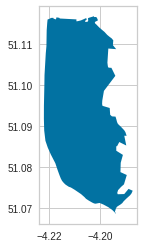

In [ ]:
shape_disp = gpd.read_file(join(aux_files, "braunton_shapefile.shp"))
shape_disp.plot()

The timeframe element of this study is slightly more complex. As we are doing a NDVI timeseries, we want the *same months* over *different years*. This will be acheived using a function, which we will see in a bit.

## 2.b Converting the shapefile to GeoJSON

For the timeseries analysis we are going to use Google Earth Engine (GEE). GEE only accepts ```GeoJSON``` as data types when working with spatial extents. To that end, we can convert our shapefile to ```GeoJSON``` using the code below. 

The ```search_area``` variable is key here. It represents the shapefile geometry, converted using ```ee.Geometry```. This ```search_area``` variable will be used to retreive all our images

In [ ]:
# CELL MODIFIED - Code modified from Heiko Balzter, practical 6

# Get the shapefile layer's extent
driver = ogr.GetDriverByName("ESRI Shapefile")
ds = driver.Open(shapefile, 0)
lyr = ds.GetLayer()
extent = lyr.GetExtent()

# get projection information of the shapefile
outSpatialRef = lyr.GetSpatialRef().ExportToWkt()
ds = None # close file

# GEE needs a special format for defining an area of interest. 
# It has to be a GeoJSON Polygon and the coordinates should be first defined 
# in a list and then converted using ee.Geometry. 
extent_list = list(extent)

# close the list of polygon coordinates by adding the starting node at the end again
# and make list elements in the form of coordinate pairs (y,x)
area_list = list([(extent[0], extent[2]),(extent[1], extent[2]),(extent[1], extent[3]),(extent[0], extent[3]),(extent[0], extent[2])])

# Convert the area_list into geometry using ee.Geometry
search_area = ee.Geometry.Polygon(area_list)

# 3. Defining an NDVI function with Google Earth Engine 

We have now defined our study area and can give GEE something that it will understand. We now want a function that will 

* Retreive all Landsat 5 images (known as a collection):
  - Within the study area
  - Within a predefined time range 
  - Over many *different* years
* Mask the cloud from the images, using the Landsat 5 band ```pixel_qa``` 
* Extract one image from the collection, for a given year
* Perform an NDVI on that image
* Save that image to the temporary folder within the Google Drive 

You will notice here that we are using the collection of images known as ```LANDSAT/LT05/C01/T1_SR``` . This is the Landsat 5 collection, and more importantly the surface reflectance product. This is important as each image has been processed to remove the effects of the atmosphere. This means can be compared accurately in timeseries.

This code is particulary efficient because GEE handles mostly everything here. The NDVI's are calculated before the image is saved to the temporary directory, meaning we only store the end result. 

In [ ]:
## Download NDVI images from Landsat 5 collection for many different years 

# Year will be a string that the user channges 
# filename will be a unique filename for the NDVI being made 

def ndvi_from_L5(year):

  """
  A function to download an NDVI scene between June-July 
  for Braunton Burrows, Devon, in a year specified by the user 
  INPUT - 
    year = A string, specifying year in the format YYYY (e.g "2005")
  OUTPUT - 
    A .tiff file representing an NDVI of Braunton Burrows, Devon. Saved the 
    temporary folder of the Google Drive account, in the format YYYY.NDVI.tif
  """
  # CELL MODIFIED - Code modified from Heiko Balzter, practical 6
  def maskclouds(image):
    # Select the cloud mask band (pixel_qa)
    # And make a cloud mask for the whole image
    band_qa = image.select('pixel_qa')
    cloud_mask = ee.Number(2).pow(10).int()
    cirrus_mask = ee.Number(2).pow(11).int()
    mask = band_qa.bitwiseAnd(cloud_mask).eq(0) and(
        band_qa.bitwiseAnd(cirrus_mask).eq(0))
    return image.updateMask(mask).divide(10000)

  # Check the working directory to where the NDVI will be saved 
  # (in the temporary folder of the Google Drive user)
  os.chdir(downloaddir)

  # Start looking at the beginning of June 
  month_start = "-06-01" 
  # Stop looking at the end of July 
  month_end = "-07-31"

  # Make a complete string of datefrom
  datefrom = year + month_start  
  # Make a complete string of dateto 
  dateto   = year + month_end  
  # Format these as lists
  time_range = [datefrom, dateto] 

  # Load in all Landsat 5 SR imagery and filter by the start dates, 
  # predefined search area and wipe out any clouds with maskclouds. Notice 
  # search_area making a comback here  
  L5 = (ee.
        ImageCollection('LANDSAT/LT05/C01/T1_SR').
        filterDate(datefrom, dateto).
        filterBounds(search_area).
        map(maskclouds))


  # Pick out the first image in the collection
  scene = L5.first()


  # Perform NDVI (still within GEE)
  nir = scene.select("B4")
  red = scene.select("B3")
  ndvi = nir.subtract(red).divide(nir.add(red)).rename("NDVI");

  # Get the download URL for the image
  # Save the file as year, at the scale of 30 m (to match Landsat 5 resolution).
  # Region also saves the image within the specified search_area
  # filePerBand may be unneccesary here as we only have one band
  
  # CELL MODIFIED - Code modified from Heiko Balzter, practical 6
  NDVI = ndvi.getDownloadURL({
        'name':year,
        'scale': 30,
        'region': search_area,
        'filePerBand': "False"
        })
  
  # CELL MODIFIED - Code modified from Heiko Balzter, practical 6
  # Download it, naming by the year
  f = requests.get(NDVI, stream =True)

  # check whether it is a zip file
  check = zipfile.is_zipfile(io.BytesIO(f.content))

  # If the file is not zipped, download it
  # If it is zipped, unzip it 
  while not check:
    f = requests.get(NDVI, stream =True)
    check = zipfile.is_zipfile(io.BytesIO(f.content))
  else:
    z = zipfile.ZipFile(io.BytesIO(f.content))
    z.extractall()

    print(year + " is complete")


# 4. Accessing NDVI's throughout the decades
We now have the power to download an NDVI for Braunton Burrows over the entire history of Landsat 5, 1984-2010. How cool is that!!??

We can define a list of years and then push those years through the function. All the NDVI's will then be saved to the temporary folder, as defined in the function. 

No image could be found for **2002**, so it was not included in the year list. Theres room here to handle for such exceptions in the future.

In [ ]:
years = ["2010", "2009", "2008", "2007", "2006", "2005", "2004", "2003", "2001",
         "1999", "1998", "1997", "1996", "1995", "1994", "1993", "1992", "1991", 
         "1990", "1989", "1988", "1987", "1986", "1985", "1984"]

## 4.a Downloading NDVI's

In [ ]:
for a_year in years:
    ndvi_from_L5(a_year)

# How many did we get? 
list = os.listdir(downloaddir) # dir is your directory path
number_files = len(list)
print(number_files)

2010 is complete
2009 is complete
2008 is complete
2007 is complete
2006 is complete
2005 is complete
2004 is complete
2003 is complete
2001 is complete
1999 is complete
1998 is complete
1997 is complete
1996 is complete
1995 is complete
1994 is complete
1993 is complete
1992 is complete
1991 is complete
1990 is complete
1989 is complete
1988 is complete
1987 is complete
1986 is complete
1985 is complete
1984 is complete
25


## 4.b Quality assurance on the NDVI outputs

While we can download all the NDVI's we want, I still think its good to check the quality by hand. Unfortunately because of Landsat 5's overpass, we don't get many chances (~4) within our 2 month slot for a clear image. If an image is cloudy, there's nothing we can do about it. It has to be dismissed. 

1984.NDVI.tif


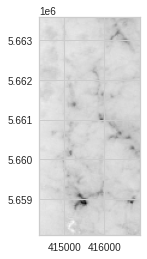

1985.NDVI.tif


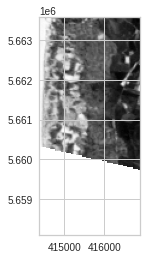

1986.NDVI.tif


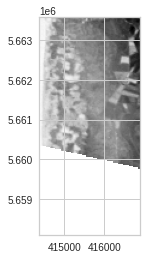

1987.NDVI.tif


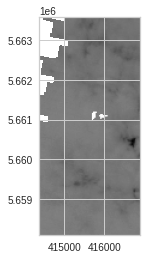

1988.NDVI.tif


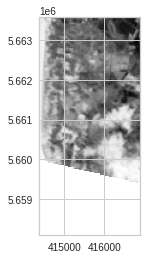

1989.NDVI.tif


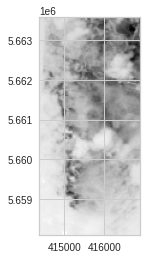

1990.NDVI.tif


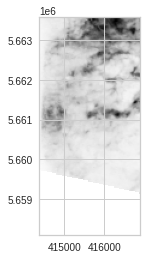

1991.NDVI.tif


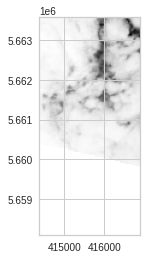

1992.NDVI.tif


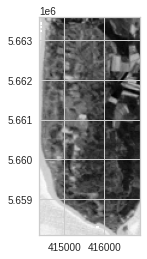

1993.NDVI.tif


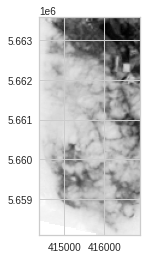

1994.NDVI.tif


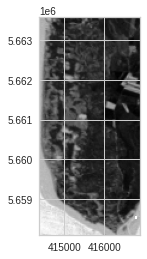

1995.NDVI.tif


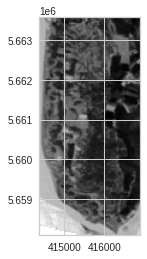

1996.NDVI.tif


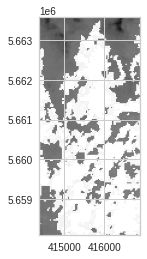

1997.NDVI.tif


/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


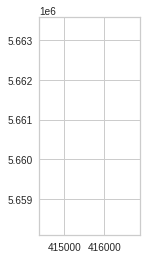

1998.NDVI.tif


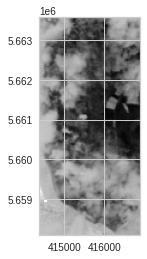

1999.NDVI.tif


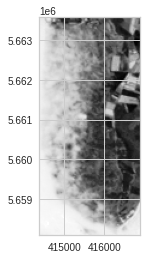

2001.NDVI.tif


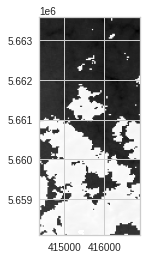

2003.NDVI.tif


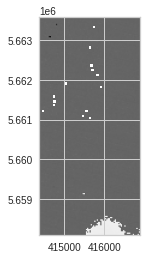

2004.NDVI.tif


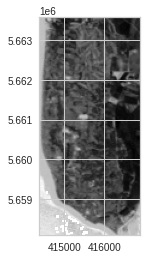

2005.NDVI.tif


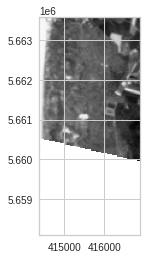

2006.NDVI.tif


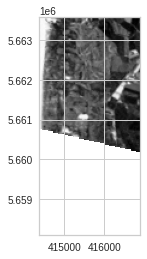

2007.NDVI.tif


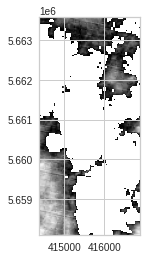

2008.NDVI.tif


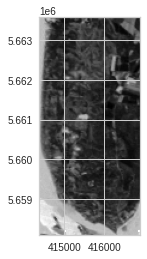

2009.NDVI.tif


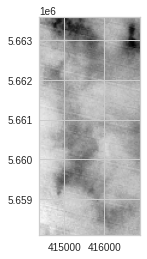

2010.NDVI.tif


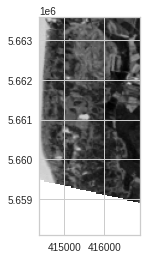

In [ ]:
for file in sorted(os.listdir(downloaddir)):
  print(file)
  with rio.open(file) as src:
    show(src)

## 4.c Removing bad images from the directory

We started with 26 files, that has now been reduced down to 12 good, cloudless images. I was expecting a 50% hit rate, so I'm not too surprised by this. It's the way remote sensing goes!

We can note down the bad images and do pattern matching with ```any``` to remove them from the directory



In [ ]:
patterns = ["2009", "2007", "2003", "2001", "1998", "1997", 
              "1996", "1993", "1991", "1990", "1989", "1988", "1987", "1984"]

In [ ]:
for f in os.listdir(downloaddir):
    if any(pattern in f for pattern in patterns):
        try:
            os.remove(os.path.join(downloaddir, f))
        except OSError:
            print("there's no such a file")

# 5. Mean and maximum NDVI throughout the images

One of our questions was 
* Has NDVI of the same pixels changed over the years?

That can be answered with ```zonal_stats```. ```zonal_stats``` passes a shapefile and an image, computing statistics within the shapefile. Some of our images are different sizes, so we need a smaller shapefile (```AOI_sub```) as ```zonal_stats``` can't compute for data that is not there.



## 5.a Review the AOI

First let's plot the the new AOI (```AOI_sub```) over an NDVI image to get some context:

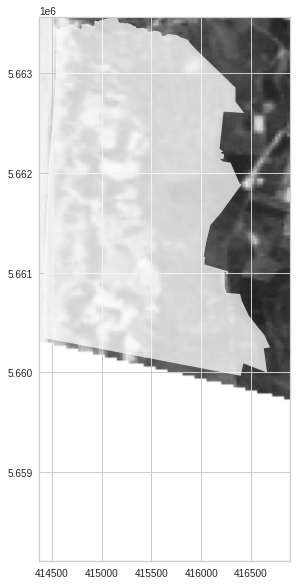

In [ ]:
# Example NDVI with CRS data
ndvi = rio.open("1985.NDVI.tif")
# Subset of the earlier seen AOI
AOI_sub = gpd.read_file(os.path.join(aux_files, "clipped_braunton_32630.shp"))

fig, ax = plt.subplots(figsize=(12, 10))
# Show the NDVi as an array, using the CRS data from it in ```transform```
show(ndvi.read(1), vmin=0, vmax=1, transform = ndvi.transform, ax=ax)
# Plot the AOI over the top
AOI_sub.plot(ax=ax, color='white', alpha=.75)
plt.show()

This works because the image ```ndvi``` and the shapefile ```AOI_sub``` have the same ```EPSG```, or coordinate reference system (CRS). This means they plot over each other as they are both in the same *projection*. Simply put, ```AOI_sub``` and ```ndvi``` are both speaking the same geograpical language. We can prove this with the following code:

In [ ]:
print("The CRS of the NDVI image is: ", ndvi.crs)
print("The CRS of the shapefile is:", AOI_sub.crs)

The CRS of the NDVI image is:  EPSG:32630
The CRS of the shapefile is: epsg:32630


So now, every pixel within that AOI will be used to calculate the following statistics. You can see some issues here. If we missed some cloud, or if one of our images isn't as good as we hope, it will give wildly different statistic to the other images.

## 5.b Pandas dataframe of statistics for each image
We now want to compute the statistics for every image that is currently in our directory. These statistics can also be saved in a ```pd.dataframe``` to make them easy to work with in the future. The workflow for the below code is:

For each image in the directory:
  * Get statistics from ```zonal_stats```
  * Clean the statisic from the ```zonal_stats``` format
  * Drop the statistics into a row of a dataframe, complete with the year
  * Format the ```year``` of the image to ```datetime```
  * Append errors from the statistic to a ```numpy``` array
 

In [ ]:


# Make an empty dataframe to load the image statistics into 
image_stats = pd.DataFrame(columns=['yyyy', 'mean_ndvi', 'min_ndvi', 'max_ndvi'])

for filename in os.listdir(downloaddir):

  os.chdir(downloaddir)
  
  # Get ndvi image from the directory
  # Get its CRS data and convert it to an array to feed into zonal_stats
  with rio.open(filename) as src:
    affine = src.transform
    array = src.read(1)
  
  # Get zonal stats for array based on shapefile bounds 
  zs = zonal_stats(os.path.join(aux_files, "clipped_braunton_32630.shp"), array, affine=affine)
  
  # Extract value for each statistic, getting rid of brackets and converting 
  # the string to float()
  mean = [ sub['mean'] for sub in zs] 
  mean_int = float(str(mean)[1:-1])

  min  = [ sub['min'] for sub in zs]
  min_int = float(str(min)[1:-1]) 

  max  = [ sub['max'] for sub in zs]
  max_int = float(str(max)[1:-1]) 

  # Strip the file name to use in the dataframe
  filename_clean = filename.replace(".NDVI.tif", '')
  filename_date = datetime.datetime.strptime(filename_clean, '%Y')

  # Append image stats to each each image 
  image_stats = image_stats.append({'yyyy': filename_clean, 
                                    'mean_ndvi': mean_int, 
                                    'min_ndvi': min_int, 
                                    'max_ndvi': max_int}, 
                                   ignore_index = True)

/usr/local/lib/python3.7/dist-packages/rasterstats/io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


Lets take a look at what we just made

In [ ]:
image_stats

,yyyy,mean_ndvi,min_ndvi,max_ndvi
0,2006,0.555454,0.000000,0.817406
1,1986,0.409175,0.169205,0.579907
2,1985,0.585244,0.102694,0.862188
3,1999,0.432445,0.073882,0.855512
4,1992,0.546938,0.122953,0.796728
5,2008,0.659346,0.101648,0.840397
6,1994,0.657396,0.105520,0.878839
7,1995,0.596340,0.143199,0.857434
8,2004,0.588191,0.082335,0.850174
9,2005,0.523326,0.000000,0.670103


So these are the statistics captured within the shapefile ```AOI_sub```, in the year ```yyyy``` of the Landsat 5 image

## 5.c NDVI time series 

We can now use this dataframe to plot the NDVI of Braunton Burrows in time series. 

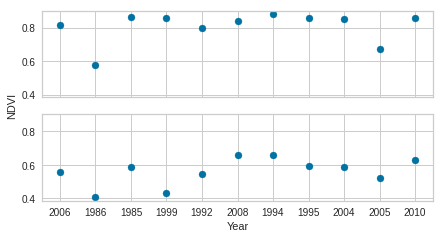

In [ ]:
dates = image_stats["yyyy"]
mean_ndvi = image_stats["mean_ndvi"]
max_ndvi = image_stats["max_ndvi"]

# Geting shared x and y labels 
fig, axs = plt.subplots(2, sharex=True, sharey=True, figsize=(7, 3.5))
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.grid(False)

# Plotting maximum NDVI
axs[0].scatter(dates, max_ndvi)
# Plotting mean NDVI
axs[1].scatter(dates, mean_ndvi)
plt.ylabel("NDVI")
plt.xlabel("Year")
plt.show()

More variation is seen in the averaged NDVI than the maximum NDVI. Additionally, **there is no large-scale trend in NDVI increase at Braunton Burrows**. 


# 6. Assessing weather data at Chivenor

The Chivenor weather data has been collected since 1951. This is a small selection of it, previously cleaned up a bit in Excel, for easier use within python. The data set starts at 1987 because after that year, rainfall data was consistently collected every month (apart from a few gaps). 

As rainfall is the focus of this study, we will read this in and plot it up:

Text(0.5, 0, 'Year')

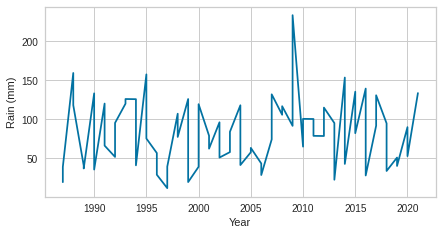

In [ ]:
chivenor = pd.read_csv(os.path.join(aux_files, "chivenor.csv"))
# Sample every nth row to get a less noisy dataset
chivenor = chivenor.iloc[::6, :]

# Get rid of no data 
chivenor = chivenor.replace("---", np.nan)
# Get year and the rain at that year 
year = chivenor["yyyy"]
rain = chivenor["rain"]
# Convert to numeric
rain = pd.to_numeric(rain)

fig, ax = plt.subplots(figsize=(7, 3.5))
ax.plot(year, rain)
plt.ylabel("Rain (mm)")
plt.xlabel("Year")

We're viewing what is essentially a very local weather pattern here. Hence, the lack of any real pattern. On such a small scale (one weather station, in one town) theres too much noise in the system to derive any large-scale, weather cycles.

## 6.a Function to plot weather data for a set month 

We will assume that the NDVI lags behind rainfall. That is, there is rainfall and then this leads to an NDVI a month or so into the future. The question is, *what is this lag?* We can write a function to return the rainfall for a set month, every year. This data can then be used in conjuction with the NDVI to discover any trends 

In [ ]:
def plot_chivenor(month_as_num):

  """
  A function to plot time series of monthly rainfall for a specific month
  (mm) at Chivenor, North Devon.
  INPUT
    - Month as a number
  OUTPUT
    - Figure of rainfall, every year at the month specified
  """
  # Set directory to where the Chivenor file is 
  os.chdir(aux_files)

  chivenor = pd.read_csv("chivenor.csv")
  chivenor = chivenor.replace("---", np.nan)
  year = chivenor["yyyy"]
  month = chivenor[chivenor["mm"] == month_as_num]
  year = month["yyyy"]
  rain = month["rain"]
  rain = pd.to_numeric(rain)
  month_as_str = str(month_as_num)

  fig, ax = plt.subplots(figsize=(7, 3.5))
  ax.scatter(year, rain)
  plt.ylabel("Rain (mm)")
  plt.xlabel("Year")
  plt.title("Month = " + month_as_str)




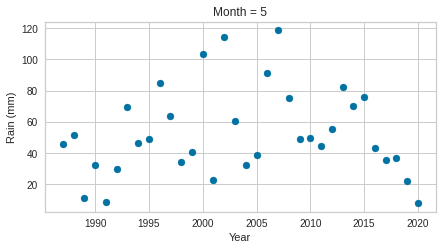

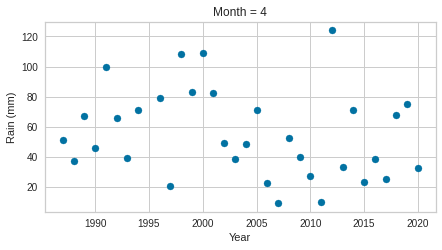

In [ ]:
# Rainfall at May, every year at Chivenor, North Devon
plot_chivenor(5)

# Rainfall at April, every year at Chivenor, North Devon 
plot_chivenor(4)

So the rain at the same time of year can vary a lot from year to year. There does not seem to be a lot of consistency with the rainfall, for a given month. 
 

## 6.b Joining weather data and NDVI data 
We now have weather data for a given month and year. We also have NDVI for the same year. We can join these datasets using ```.merge```. We can then plot *lagged* weather data with NDVI to explore any correlation. Before, we were just looking at rain. However because the data is available, we can also review how NDVI changes with maximum monthy temperatures (```tmax```) and minimum monthly temperatures (```tmin```). 

Because mean NDVI showed more variation than the maximum NDVI, mean NDVI will be used from now on. 

In [ ]:
def NDVI_rain(month_as_num, weather_variable):

  """
  This is function to retrieve the relationship between NDVI at Braunton Burrows 
  and the weather data collected at the same period, at Chivenor Met Office 
  weather station. The variable image_stats must be in the session
  INPUT
    - Month as a number
    - The weather variable you want, as shown in the Chivenor file 
  OUTPUT
    - Figure of NDVI plotted against the weather variable
  """
  # Set working directory for the Chivenor dataset
  os.chdir(aux_files)

  # Set the year in image_stats as int, to aid merging 
  image_stats["yyyy"] = image_stats["yyyy"].astype(int)

  # Chivenor weather data
  chivenor = pd.read_csv("chivenor.csv")
  chivenor = chivenor.replace("---", np.nan)
  # Extract data for a month of every year in the Chivenor weather data 
  month = chivenor[chivenor["mm"] == month_as_num]

  # Merge the weather data and NDVI data on yyyy
  image_rain = image_stats.merge(month, on="yyyy", how="left")

  ndvi = image_rain["mean_ndvi"]
  weather = image_rain[weather_variable]

  month_as_str = str(month_as_num)

  fig, ax = plt.subplots(figsize=(7, 3.5))
  ax.scatter(weather, ndvi)
  plt.ylabel("mean_ndvi")
  plt.xlabel(weather_variable)
  plt.title(month_as_str)

## 6.c Plotting weather variables and NDVI

We can now use the function to plot the weather variables with the NDVI. We can go wild here, swapping out months and weather variables to explore a range of relationships. 

We were originally just interested in rain but considering we have all the weather variables (```tmin```, ```tmax```) we might aswell explore a few of them aswell 

TypeError: ignored

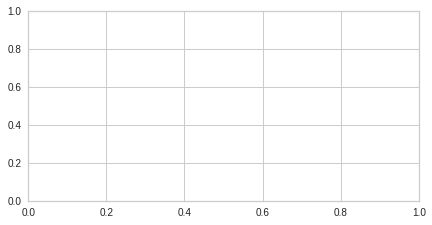

In [ ]:
NDVI_rain(2, "rain")
NDVI_rain(3, "rain")
NDVI_rain(4, "rain")
NDVI_rain(5, "rain")

So, judging by this month 3 (March) seems to correlate best with NDVI in June-July. Lets investigate the other weather variables

In [ ]:
NDVI_rain(2, "tmin")
NDVI_rain(3, "tmin")
NDVI_rain(4, "tmin")
NDVI_rain(5, "tmin")

Minimum temperature does not show a lot of correlation 

In [ ]:
NDVI_rain(2, "tmax")
NDVI_rain(3, "tmax")
NDVI_rain(4, "tmax")
NDVI_rain(5, "tmax")

The maximum temperature also does not show a lot of correlation. The 3rd month (March) rainfall with NDVI seemed to show the most interesting pattern, as shown below. 

In [ ]:
NDVI_rain(3, "rain")

So, an increase in rainfall in March seems to bring an increase in NDVI in June-July. 

#7. Building a simple linear regression model to predict NDVI from rainfall

We have noticed some kind of relationship between NDVI in June-July and rainfall with in the previous March. This can be assesed further with a linear regression model. The question is:

*Given a rainfall in March, could we predict the NDVI in June/July?*

The linear equation for this looks like:

In [ ]:
from IPython.display import HTML, Math
display(HTML("<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/"
             "latest.js?config=default'></script>"))
Math(r"NDVI = B_1 * rain + B_2")

Where B1 is some coefficient and B2 is the y-intercept

##7a. Collating the data 

To collate the data, we want the dataframe that we had before, except just for the month of March. We'll then extract the feature ```rain``` and the target ```ndvi``` to build the model. 

In [ ]:
# Check working directory
os.chdir(aux_files)

# Set the year in image_stats as int, to aid merging 
image_stats["yyyy"] = image_stats["yyyy"].astype(int)

# Chivenor weather data
chivenor = pd.read_csv("chivenor.csv")
chivenor = chivenor.replace("---", np.nan)

# Extract data for a month of every year in the Chivenor weather data 
chivenor_march = chivenor[chivenor["mm"] == 3]

# Merge the weather data and NDVI data on yyyy
march_stats = image_stats.merge(chivenor_march, on="yyyy", how="left")
march_stats


,yyyy,mean_ndvi,min_ndvi,max_ndvi,mm,tmax,tmin,af,rain
0,2006,0.555454,0.000000,0.817406,3.0,9.5,3.9,3,74
1,1986,0.409175,0.169205,0.579907,NaN,NaN,NaN,NaN,NaN
2,1985,0.585244,0.102694,0.862188,NaN,NaN,NaN,NaN,NaN
3,1999,0.432445,0.073882,0.855512,3.0,11.2,4.7,1,39.4
4,1992,0.546938,0.122953,0.796728,3.0,11,5.4,1,50.3
5,2008,0.659346,0.101648,0.840397,3.0,10.4,5,1,84.8
6,1994,0.657396,0.105520,0.878839,3.0,11.3,6.3,1,96.4
7,1995,0.596340,0.143199,0.857434,3.0,NaN,NaN,NaN,64.6
8,2004,0.588191,0.082335,0.850174,3.0,11.1,4,7,49.8
9,2005,0.523326,0.000000,0.670103,3.0,11.4,5.2,4,56


Shown above, is the output of ```NDVI_rain()``` for the month of March. Each row represents March in the year ```yyyy```. 

## 7b. Making a ```df``` for the model

The data needs cleaning for the model. For instance, ```sklearn``` does not like ```NaN``` values or ```dtype=Object```. Both of these are present in our data set. The ```NaN```'s can be seen in ```march_stats```

We will make a new dataframe and clean up the data from there

In [ ]:
# Make a new dtaframe, which will just hold rainfall and NDVI
model_data = pd.DataFrame(columns={"ndvi", "rain"})

# Get the NDVI from image_rain and drop it in 
model_data["ndvi"] = march_stats["mean_ndvi"]

# Get the rain from image_rain and drop it in
model_data["rain"] = march_stats["rain"]

# Drop rows containing NA's from the dataframe
model_data = model_data.dropna()

print("The old data types were: \n", model_data.dtypes)

# Convert the data to all numeric (float64 to be precise)
model_data = model_data.apply(pd.to_numeric)
print(" \n The new data types are: \n", model_data.dtypes)

model_data

The old data types were: 
 rain     object
ndvi    float64
dtype: object
 
 The new data types are: 
 rain    float64
ndvi    float64
dtype: object


,rain,ndvi
0,74.0,0.555454
3,39.4,0.432445
4,50.3,0.546938
5,84.8,0.659346
6,96.4,0.657396
7,64.6,0.596340
8,49.8,0.588191
9,56.0,0.523326
10,52.6,0.631637


We now have our ```model_data``` in the correct format with no ```NaN```'s. This can now be used to run a linear model 

## 7c. Running the model

Now to the fun part! We extract our feature ```rain``` and our target ```ndvi``` and use them to fit a linear regression model. This will retrieve the coefficient and the y-intercept stated in the earlier equation. Once the equation is solved, we could give the model any rainfall and predict an NDVI for the following June-July 

* ```feature``` = The predictor
* ```target``` = The varible being predicted

In [ ]:
# Save the feature - rain
features = ['rain']
# Save the target - NDVI
target = 'ndvi'

# Extract feature data from model_data
# We also reshape to suit the linear regression input 
X = model_data[features].values.reshape(-1, len(features))

# Extract target data from model_data
y = model_data[target].values

# Fit x and y with a linear regression model
ols = linear_model.LinearRegression()
model = ols.fit(X, y)

#Print the coefficient and the intercept
print("The coefficient is: \n", model.coef_)
print("The y-intercept is: \n", model.intercept_)
print("The R2 score for the model is: \n", model.score(X, y))

## 7d. Model evalution

So, the linear equation we defined earlier to calculate NDVI is:

In [ ]:
display(HTML("<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/"
             "latest.js?config=default'></script>"))
Math(r"NDVI = 0.002 * rain + 0.4")

Additionally, the ```R2 = 0.51``` means that rainfall in March can explain 51% of the variance seen in NDVI in June-July. This is not too bad, an ```R2 = 0.6-0.7``` would have been nicer but for the limted data we have, this is ok. This also suggests that the NDVI is caused by other variables we are not accounting for. This is certainly true. NDVI is almost definitely affected by sunshine hours, fluxuations in temperature, CO2 concentrations, wind and a whole host of other environmental factors that we have not considered.

## 7e. Model visualisation 

Now we have a model, we can form a prediction line for more ```feature``` values. That is, create a mock-up set of rainfall data points, and using the model, calculate NDVI for each point. This will give us a good visualisation on the relationship between rainfall and NDVI. 

Note, when making this mock data set we have to be careful. Our rainfall here ranges between 40-85 and we have stated the relationship as linear. Outside of the bounds of this data, the relationship may behave in a different way (non-linear). Due to that, we can only create data points that are within the realms of our original dataset. 

For the visualisation of the model output, the student would also like to recognise [this post](https://aegis4048.github.io/mutiple_linear_regression_and_visualization_in_python)

In [ ]:
# 200 data points between 30 mm and 100 mm 
x_pred = np.linspace(30, 100, 200)
# Reshape for scikit-learn
x_pred = x_pred.reshape(-1, len(features))

# Calculate y on X, using the model (model.predict()) we made earlier 
y_pred = model.predict(x_pred)

plt.style.use('default')
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(10, 5))

# Plot the modelled data as a line - A visual representation of the equation
ax.plot(x_pred, y_pred, color='b', label='Regression model')
# Plot the "real-life" data
ax.scatter(X, y, edgecolor='r', facecolor='red', alpha=0.7, label='Sample data')
ax.set_ylabel('NDVI (June-July)', fontsize=17)
ax.set_xlabel('Rainfall (March [mm])', fontsize=17)
ax.legend(facecolor='white', fontsize=14)
ax.tick_params(labelsize = 14)
ax.text(0.539, 0.20, '$NDVI = %.4f _{rainfall} + %.1f $' % (model.coef_[0], abs(model.intercept_)), fontsize=17, transform=ax.transAxes)
ax.text(0.539, 0.05, '$R^2 = %.2f$' % (abs(model.score(X, y))), fontsize=12, transform=ax.transAxes)

os.chdir(aux_files)
plt.savefig("NDVI_rainfall.png", bbox_inches = "tight")
fig.tight_layout()

## 7f. Model evaluation 

To determine the error of our model, we can take the **root mean squared error** (MSE). RMSE is the difference between the "real-life" target vales and the target values predicted by the model. In other words, it is the distance between every red point to the blue line, in the figure above. This distance is called the resdiual. Calculating the resduals of the model is demonstrated below: 

Note, the ```squared = False``` argument is used to convert the error back into *useful* units

In [ ]:


# Extract target data from model_data
y = model_data[target].values

# Extract feature data from model_data
# We also reshape to suit the linear regression input 
X = model_data[features].values.reshape(-1, len(features))


# Use the model to predict Y, using the same feature values 
# available to the model 
y_pred = model.predict(X)

# Calculate MSE between the "real_life" data and the predicted data, both using 
# the same feature data
print("The RMSE of the model is: \n", mean_squared_error(y, y_pred, squared=False))

That is to say, the model is *missing* "real-life" NDVI values by 0.04. Given the margins we are working with (0.4-0.6) and the fact that we are fitting a linear model to a system that may not be linear, this is a fair result. Though there is also room for improvement here aswell (see section.9).

## Implemeting MAPE
Look [here](https://www.dataquest.io/blog/understanding-regression-error-metrics/) and [here]() for more details

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mean_absolute_percentage_error(y, y_pred)

## Assessing the residuals

In [ ]:
residuals = y-y_pred

In [ ]:
X = X.reshape((9, ))
residuals = residuals.reshape((9, ))

In [ ]:
z = np.polyfit(X, residuals, 1)
p = np.poly1d(z)

In [ ]:
residuals = residuals.reshape((9,1))

In [ ]:

fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(X, residuals, "bo")
plt.plot(X, p(X), "r")
plt.ylabel('Residual', fontsize=17)
plt.xlabel('Rainfall (March [mm])', fontsize=17)
plt.tick_params(labelsize = 14)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = sns.regplot(x = residuals, y = y_pred, data = None, scatter = True, color = 'red')
plt.xlabel("Residuals", fontsize = 17)
plt.ylabel("NDVI", fontsize = 17)
plt.tick_params(labelsize = 14)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.hist(residuals, bins = 5, ec='black')
plt.xlabel("Residual", fontsize = 17)
plt.ylabel("Frequency", fontsize = 17)
plt.tick_params(labelsize = 14)

# , align = "left"

In [ ]:
normal_ad(residuals)[1]


# 8. Conclusion
We have found that: 
* There is no clear evidence that Braunton Burrows greened year on year, in the period reviewed in this study (1984-2010)
* There is no clear pattern to rainfall at Braunton Burrows
* Rainfall in March explains 51% of the variance seen in the NDVI of the following June-July 
  - A linear model representing this relationship faired adequately ($r^2$ = 0.51, $RMSE$ = 0.04), highlighted that increase in prior rainfall leads to increased NDVI of Braunton Burrows
  - This is important because with a changing climate, we may see imapcts on the rainfall at our coasts. This could then directly influence the greening of our dunes 
 



# 9. Future work..
There is a lot of scope here for future work, some of which is listed below

* Include Landsat 8 for more recent time series up to the present
  - How will the change in bands change the NDVI? 
* Performing multiple linear regression with NDVI as the target
  - Explain the other 48% of the variance
  - Other weather variables from the Met Office dataset
  - Include CO2 data from [Giovanni](https://giovanni.gsfc.nasa.gov/giovanni/)
* What does the relationship look like if we normalize the rainfall?
* How does the relationship here compare to other beaches in the area? 




# Appendix

A. Gif of the images used in this analysis 

In [ ]:

# create an empty Numpy array where we will merge all raster images
images = []

os.chdir(downloaddir)

# iterate over all zoom files
for f in sorted(os.listdir(downloaddir)):
  images.append(imageio.imread(f)) # read the next image and append it

# Let's set the frame rate to 3 seconds.
framerate = { 'duration': 2 }

# save the movie
imageio.mimsave(join(downloaddir, "movie.gif"), images, **framerate)